In [65]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Chapter 3.5 exercises

This function simulates the accuracy surface of a support-vector machine (SVM) model in a hyperparameter tuning task. The x-axis denotes the value of the penalty parameter $c$, while the y-axis denotes the value for the RBF kernel parameter $\gamma$. 

In [66]:
def f(x1, x2):
    term1 = torch.sin((5*x1 - 5) / 2)
    term2 = torch.cos(2.5 - 5*x2)
    term3 = (1/10) * torch.pow((5*x2 + 1) / 2, 2)
    return term1 * term2 + term3

In [78]:
x1 = torch.linspace(0, 2, 100) # C
x2 = torch.linspace(0, 2, 100) # gamma
x1, x2 = torch.meshgrid(x1, x2)
Z = -f(x1, x2)

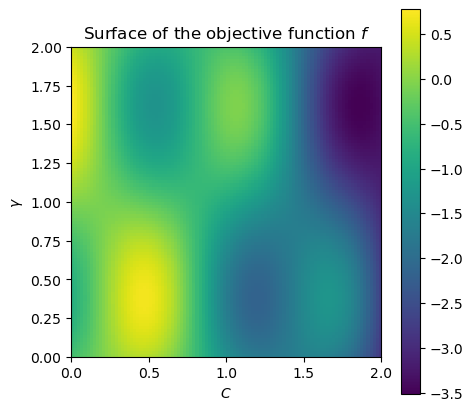

In [79]:
plt.figure(figsize=(5, 5))
plt.imshow(Z, extent=[0, 2, 0, 2], origin="lower")
plt.xlabel("$C$")
plt.ylabel("$\\gamma$")
plt.title("Surface of the objective function $f$")
plt.colorbar();

## Optimize using stochastic gradient descent

In [ ]:
torch.randn()

Initialization: x1 = tensor([-0.1635], requires_grad=True), x2 = tensor([-0.2505], requires_grad=True)
Optimal values: x1 = tensor([0.2461], requires_grad=True), x2 = tensor([-0.1243], requires_grad=True)


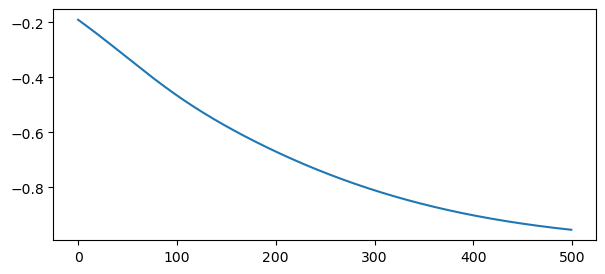

In [85]:
# initialize x1 and x2 with random values
x1 = torch.randn(1, requires_grad=True)
x2 = torch.randn(1, requires_grad=True)

print(f"Initialization: x1 = {x1}, x2 = {x2}")

# Use SGD as the optimizer
optimizer = torch.optim.Adam([x1, x2], lr=0.001)

# Run optimization loop
loss = []
iterations = 500
for i in range(iterations):
    optimizer.zero_grad()
    output = -f(x1, x2)
    output.backward()
    optimizer.step()
    loss.append(output.item())

print(f"Optimal values: x1 = {x1}, x2 = {x2}")

plt.figure(figsize=(7, 3))
plt.plot(torch.arange(iterations), loss);

Function evaluation: tensor([-0.9545], grad_fn=<NegBackward0>)


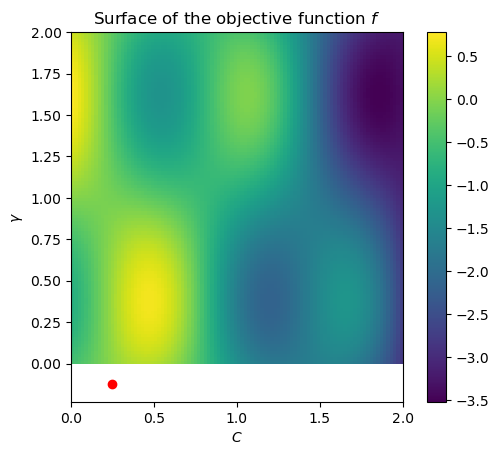

In [86]:
print(f"Function evaluation: {-f(x1, x2)}")

plt.imshow(Z, extent=[0, 2, 0, 2], origin="lower")
plt.xlabel("$C$")
plt.ylabel("$\\gamma$")
plt.title("Surface of the objective function $f$")
plt.colorbar()
plt.scatter(x1.item(), x2.item(), c="red");

## Lengthscales

### Constant lengthscale across features

In [71]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu,
                ard_num_dims=None
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [72]:
torch.manual_seed(0)
train_x = torch.rand(size=(100, 2)) * 2
train_y = f(train_x[:, 0], train_x[:, 1])

100%|██████████| 500/500 [00:00<00:00, 652.49it/s]


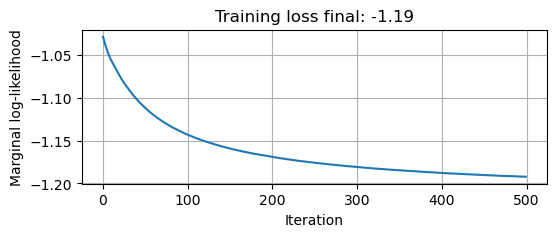

In [73]:
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(train_x, train_y, likelihood, nu=2.5)

model.lengthscale = lengthscale
model.likelihood.noise = noise

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# enable training mode
model.train()
likelihood.train()

# training loop
iterations = 500
losses = []
for i in tqdm(range(iterations)):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(6, 2))
plt.plot(
    torch.arange(iterations),
    losses
)
plt.xlabel("Iteration")
plt.ylabel("Marginal log-likelihood")
plt.grid(True)
plt.title(f"Training loss final: {loss:.2f}");

In [55]:
# lengthscale inspection (assuming constant lengthscale across input dimensions)
model.covar_module.base_kernel.lengthscale

tensor([[1.0075]], grad_fn=<SoftplusBackward0>)

### Varying lengthscales with automatic relevance determination (ARD)

Using the `gpytorch.kernels.ScaleKernel` class.

In [56]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu,
                ard_num_dims=2
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

100%|██████████| 500/500 [00:00<00:00, 542.33it/s]


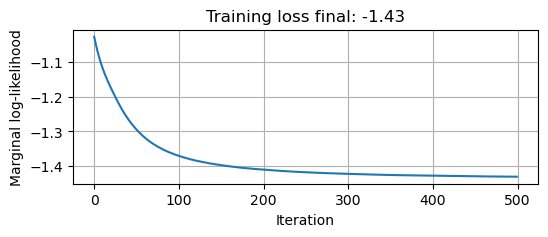

In [64]:
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(train_x, train_y, likelihood, nu=2.5)

model.lengthscale = lengthscale
model.likelihood.noise = noise

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# enable training mode
model.train()
likelihood.train()

# training loop
iterations = 500
losses = []
for i in tqdm(range(iterations)):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(6, 2))
plt.plot(
    torch.arange(iterations),
    losses
)
plt.xlabel("Iteration")
plt.ylabel("Marginal log-likelihood")
plt.grid(True)
plt.title(f"Training loss final: {loss:.2f}");

In [59]:
model.covar_module.base_kernel.lengthscale

tensor([[1.5607, 0.8324]], grad_fn=<SoftplusBackward0>)